In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
% matplotlib inline

In [2]:
#Steps to generate
T = 10000

# Specify the hazard function.
# This is a handle to a function that takes one argument - the number of
# time increments since the last changepoint - and returns a value in
# the interval [0,1] that is the probability of changepoint.  Generally
# you might want to have your hazard function take parameters, so using
# an anonymous function is helpful.  We're going to just use the simple
# constant-rate hazard function that gives geomtrically-drawn intervals between changepoints.  
# We'll specify the rate via a mean.

lambd = 0.0005
def hazard_func(r):
    return lambd

# This data is Gaussian with unknown mean and variance.  We are going to
# use the standard conjugate prior of a normal-inverse-gamma.  Note that
# one cannot use non-informative priors for changepoint detection in
# this construction.  The NIG yields a closed-form predictive
# distribution, which makes it easy to use in this context.  There are
# lots of references out there for doing this kind of inference - for
# example Chris Bishop's "Pattern Recognition and Machine Learning" in
# Chapter 2.  Also, Kevin Murphy's lecture notes.

mu0    = 0
kappa0 = 1
alpha0 = 1
beta0  = 1

# This will hold the data.  Preallocate for a slight speed improvement.
X = np.zeros(T)

# Store the times of changepoints.  It's useful to see them.
CP = [0]

In [3]:
# Generate the initial parameters of the Gaussian from the prior.
curr_ivar = np.random.gamma(alpha0)/beta0;
curr_mean = pow((kappa0*curr_ivar),(-0.5))*np.random.normal() + mu0;

In [4]:
#The initial run length is zero
curr_run = 0;

In [5]:
#Now, loop forward in time and generate data.
for t in range(0,T):
    # Get the probability of a new changepoint.
    p = hazard_func(curr_run)
    
    # Randomly generate a changepoint, perhaps.
    if np.random.uniform() < p:
        
        # Generate new Gaussian parameters from the prior.
        curr_ivar = np.random.gamma(alpha0)*beta0
        curr_mean = pow((kappa0*curr_ivar), (-0.5))*np.random.normal() + mu0
        
        # The run length drops back to zero.
        curr_run = 0
        
        # Add this changepoint to the end of the list.
        CP.append(t)
    else:
        # Increment the run length if there was no changepoint.
        curr_run = curr_run + 1
        
    # Draw data from the current parameters.
    X[t] = pow(curr_ivar, (-0.5)) * np.random.normal() + curr_mean

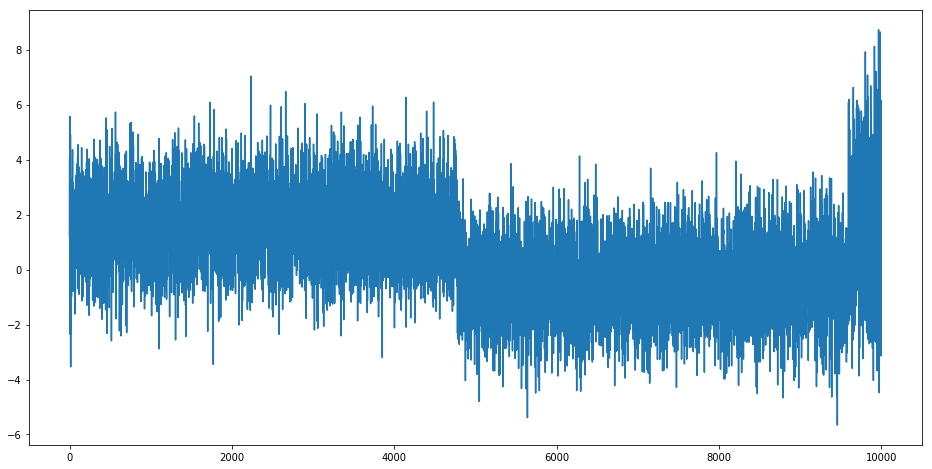

In [6]:
plt.figure(figsize=(16,8))
plt.plot(range(0,T), X)

In [7]:
class BCODAlgorithm:
    def __init__(self,
                hazard_constant=0.0005,
                mu_initial   = 0,
                kappa_initial = 1,
                alpha_initial = 1,
                beta_initial  = 1):
        self.__lambda = hazard_constant
        self.__mu0 = mu_initial
        self.__kappa0 = kappa_initial
        self.__alpha0 = alpha_initial
        self.__beta0 = beta_initial
        
        
    def inference(self, data):
        # Now we have some data in X and it's time to perform inference.
        # First, setup the matrix that will hold our beliefs about the current
        # run lengths.  We'll initialize it all to zero at first.  Obviously
        # we're assuming here that we know how long we're going to do the
        # inference.  You can imagine other data structures that don't make that
        # assumption (e.g. linked lists).  We're doing this because it's easy.
        R= np.zeros([len(data)+1, len(data)])
        
        # At time t=1, we actually have complete knowledge about the run
        # length.  It is definitely zero.  See the paper for other possible
        # boundary conditions.
        R[0,1] = 1
        
        # Track the current set of parameters.  These start out at the prior and
        # accumulate data as we proceed.
        muT    = np.array([self.__mu0])
        kappaT = np.array([self.__kappa0])
        alphaT = np.array([self.__alpha0])
        betaT  = np.array([self.__beta0])
        
        # Keep track of the maximums.
        maxes  = np.zeros(len(data)+1);
        
        # Loop over the data like we're seeing it all for the first time.
        for t in range(1,len(data) - 1):

            # Evaluate the predictive distribution for the new datum under each of
            # the parameters.  This is the standard thing from Bayesian inference.
            predprobs = self.studentpdf(X[t], muT, betaT*(kappaT+1)/(alphaT*kappaT), 2 * alphaT);

            # Evaluate the hazard function for this interval.
            H = self.hazard_func(t);

            # Evaluate the growth probabilities - shift the probabilities down and to
            # the right, scaled by the hazard function and the predictive
            # probabilities.
            R[1:t+1,t+1] = R[0:t,t]* predprobs * (1-H);

            # Evaluate the probability that there *was* a changepoint and we're
            # accumulating the mass back down at r = 0.
            R[0,t+1] = sum((R[0:t,t] * predprobs * H).flatten() );

            # Renormalize the run length probabilities for improved numerical
            # stability.
            R[:,t+1] = R[:,t+1] / sum(R[:,t+1]);

            # Update the parameter sets for each possible run length.
            muT0    = np.vstack([mu0, (kappaT*muT + X[t]) / (kappaT+1)])
            kappaT0  = np.vstack([kappa0, kappaT + 1])
            alphaT0  = np.vstack([ alpha0 , alphaT + 0.5 ])
            betaT0   = np.vstack([ beta0  , betaT + (kappaT *pow((X[t]-muT),2))/(2*(kappaT+1)) ])

            muT = muT0
            kappaT = kappaT0
            alphaT = alphaT0
            betaT = betaT0

            # Store the maximum, to plot later.
            maxes[t] = self.find_max_indicies(R[:,t])
        return R, maxes
    
    def studentpdf(self, x, mu, var, nu):
        # This form is taken from Kevin Murphy's lecture notes.
        c = np.exp(sp.gammaln(nu/2 + 0.5) - sp.gammaln(nu/2)) * pow((nu*np.pi*var), (-0.5))  
        return (c * pow((1 + (1/(nu*var))*pow((x-mu),2)), (-(nu+1)/2))).transpose()
    
    def find_max_indicies(self, arr):
        maximum = max(arr)
        indicies = []
        for i in range(0, len(arr)):
            if arr[i] == maximum:
                indicies.append(i)
        return np.array(indicies)
    
    def hazard_func(self, r):
        return self.__lambda

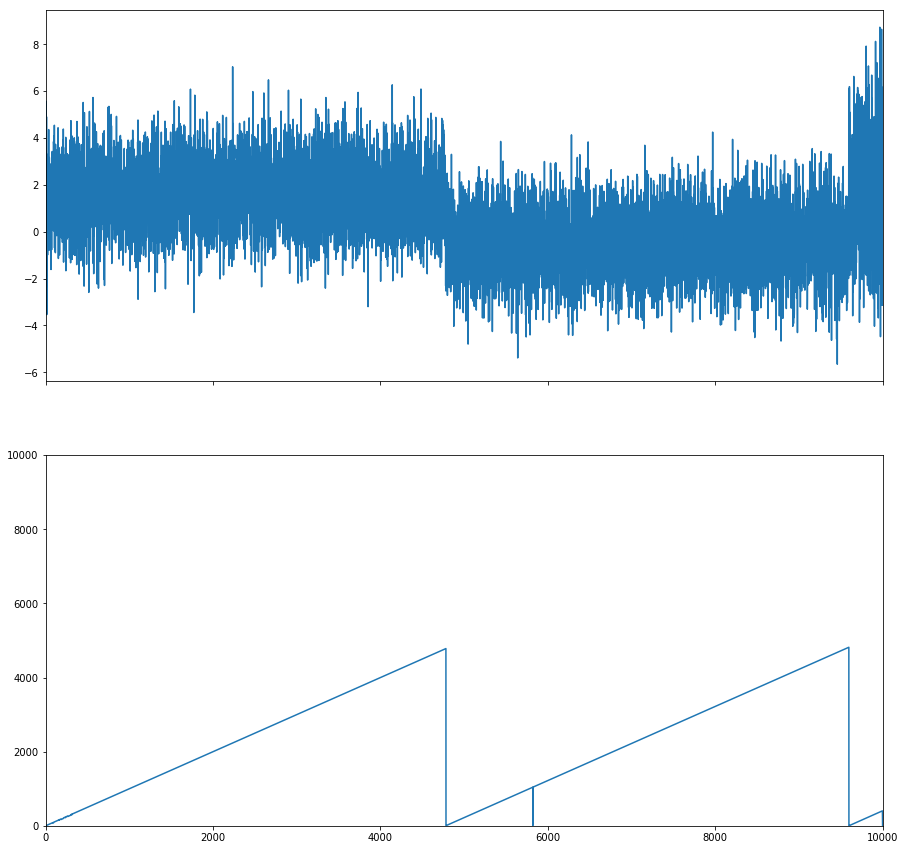

In [8]:
bcod = BCODAlgorithm()
result, most_probable_path = bcod.inference(X)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15), sharex=True)
ax1.set_xlim(0, T)
ax2.set_ylim(0, T)
ax1.plot(range(0,T), X)
ax2.plot(range(0,T + 1), most_probable_path)